importation des bibliothéques pour notre trvail de prediction de prix d'ordinateurs

In [37]:
import tensorflow as tf
import pandas as pd
import seaborn as sea
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import numpy as np

**Preparation des données**

1- *assignation a une variables*

In [38]:
donnee = pd.read_csv("laptop_data_cleaned.csv",",")
donnee.head()

<ipython-input-38-222fbeea4987>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  donnee = pd.read_csv("laptop_data_cleaned.csv",",")


,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.175755,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.776777,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.329931,0,0,141.211998,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.814476,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.473101,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


verification de l'etendu des données (inspection des données)

In [39]:
donnee.shape

(1273, 13)

dans cette section on ne vas que utilisé les colonne ayant des valeurs etant des chiffres.

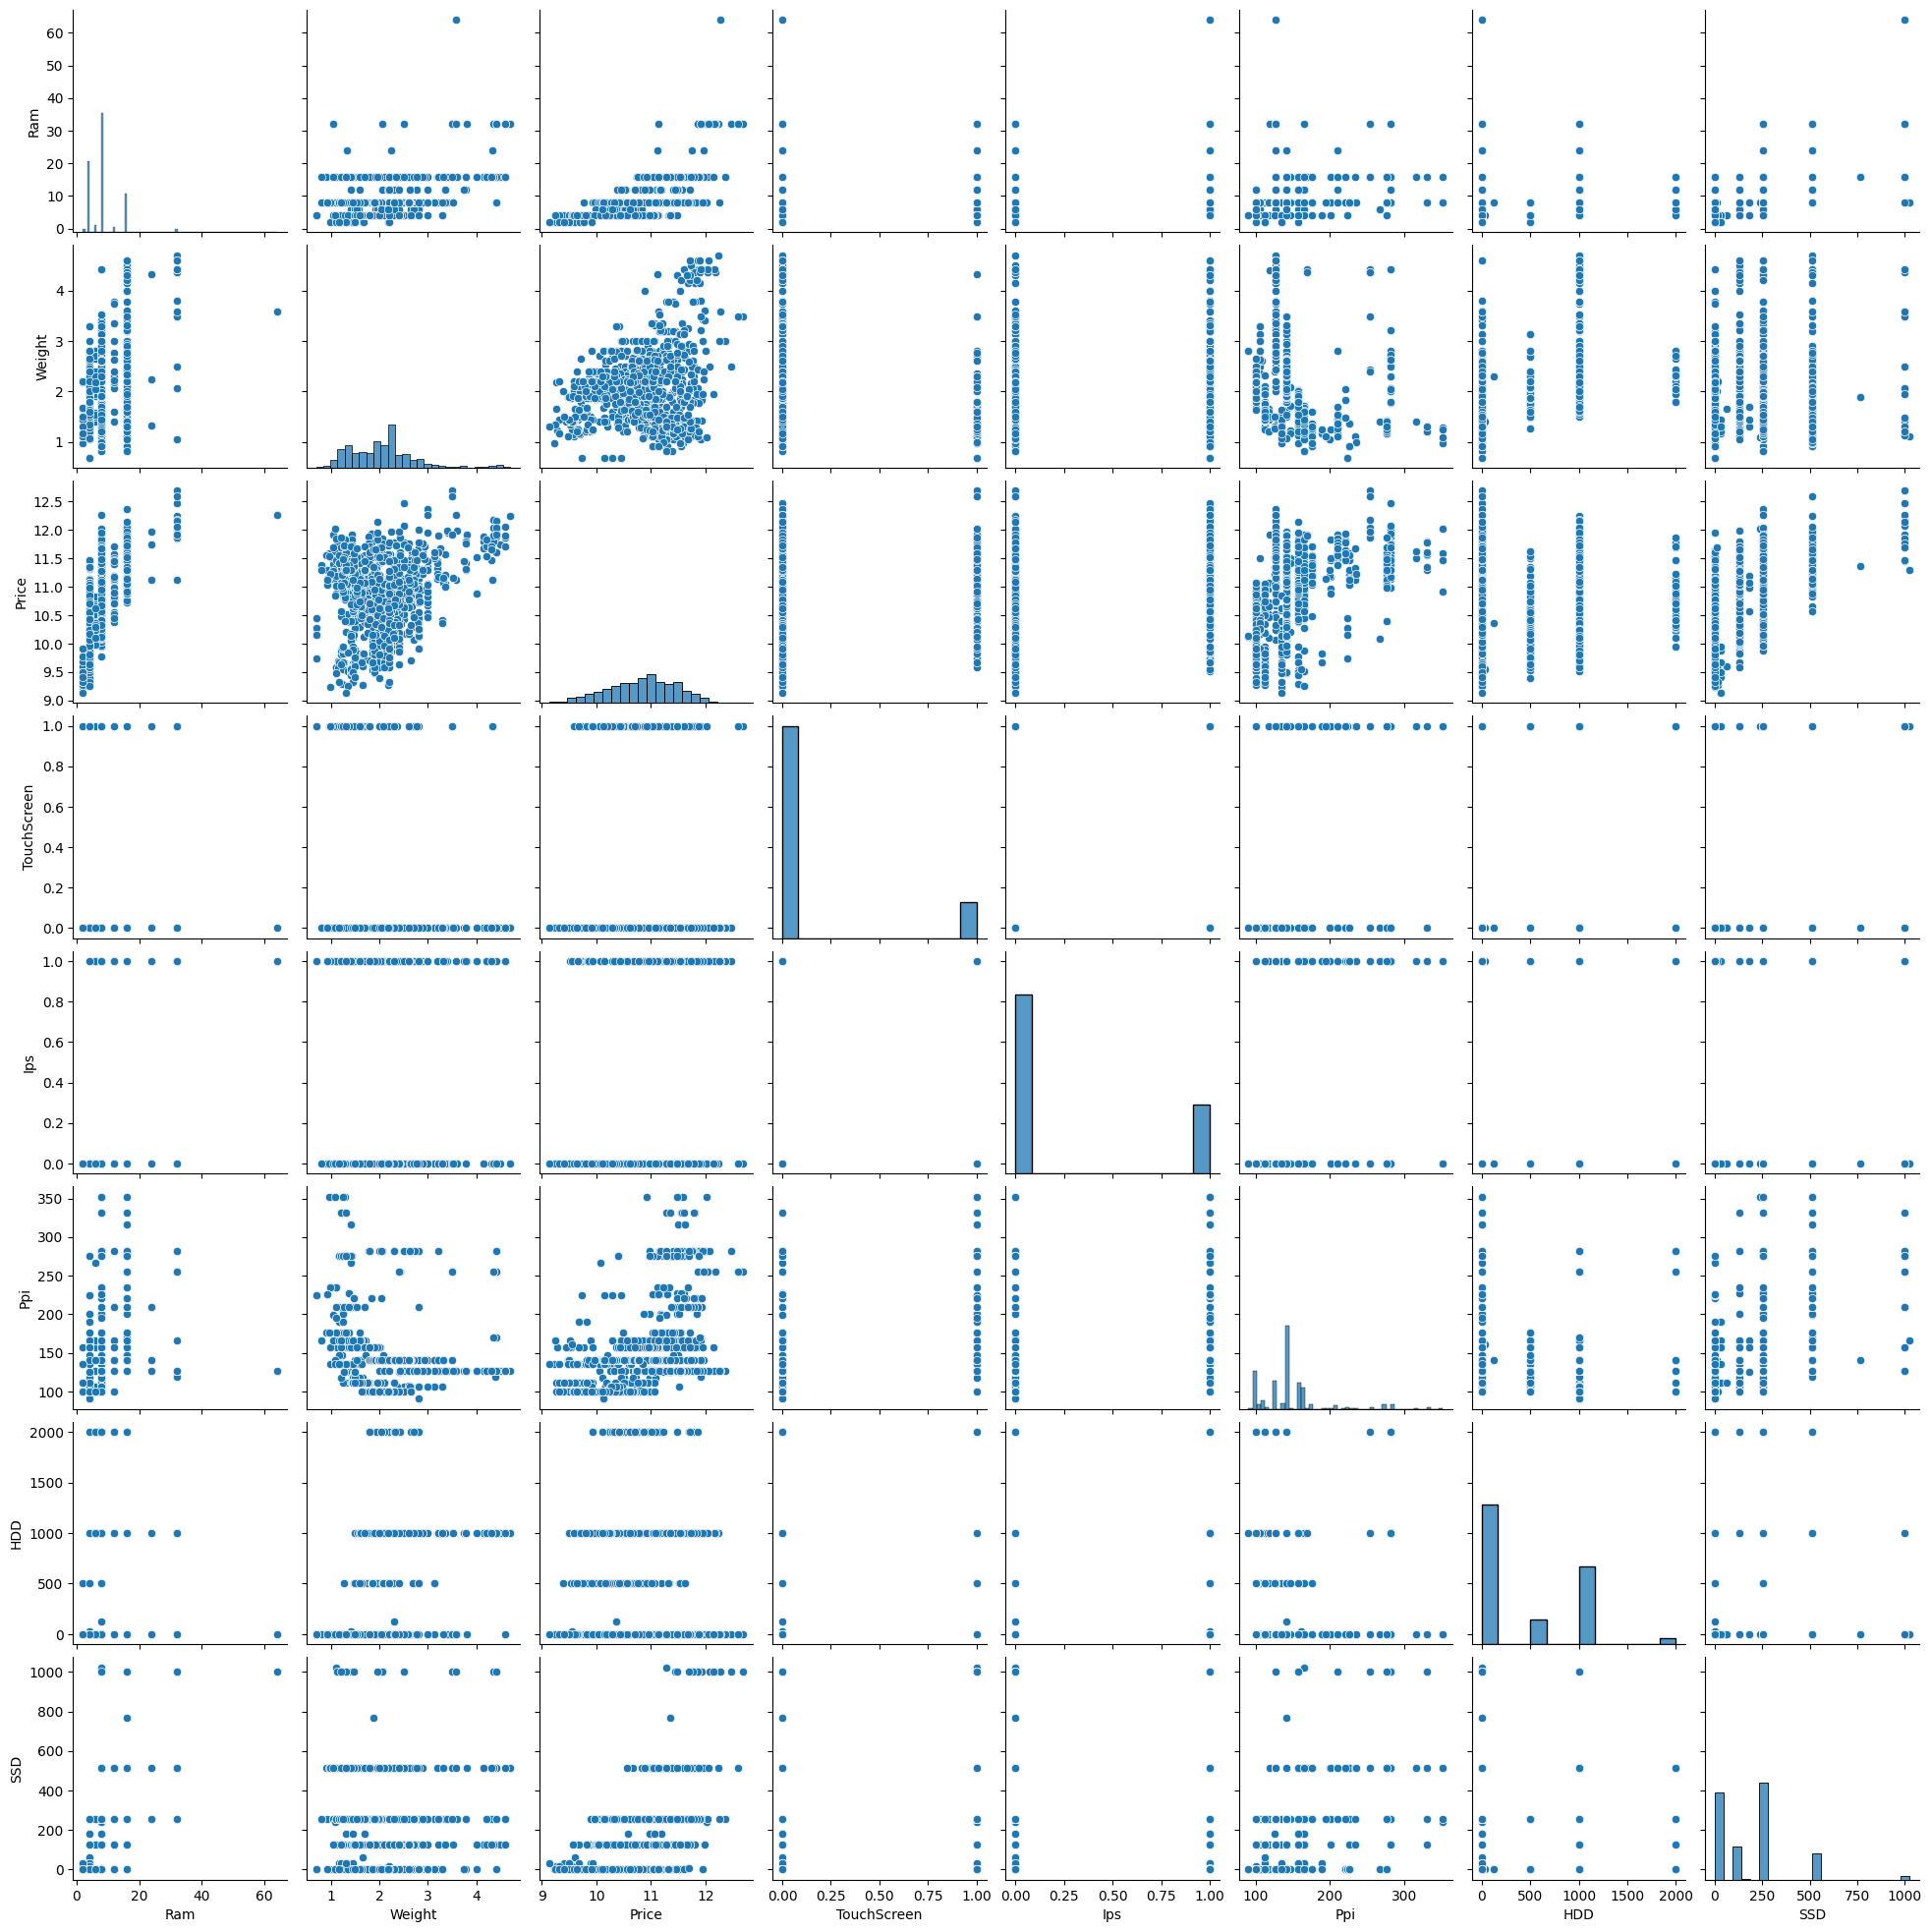

In [28]:
entree = donnee[['Ram', 'Weight', 'Price', 'TouchScreen', 'Ips', 'Ppi','HDD', 'SSD']]
sea.pairplot(entree, diag_kind ='hist')

In [95]:

entree.head()


,Ram,Weight,Price,TouchScreen,Ips,Ppi,HDD,SSD
0,8,1.37,11.175755,0,1,226.983005,0,128
1,8,1.34,10.776777,0,0,127.677940,0,0
2,8,1.86,10.329931,0,0,141.211998,0,256
3,16,1.83,11.814476,0,1,220.534624,0,512
4,8,1.37,11.473101,0,1,226.983005,0,256


In [94]:
entree.shape

(1273, 8)

conversion de nos données en tenseur

In [42]:
tenseur_donnee = tf.constant(entree)
tenseur_donnee = tf.cast(tenseur_donnee, tf.float32)
print(tenseur_donnee)

tf.Tensor(
[[   8.          1.37       11.175755 ...  226.983       0.
   128.      ]
 [   8.          1.34       10.776777 ...  127.67794     0.
     0.      ]
 [   8.          1.86       10.329931 ...  141.212       0.
   256.      ]
 ...
 [  16.          1.3        11.288115 ...  276.05353     0.
   512.      ]
 [   2.          1.5         9.409283 ...  111.9352      0.
     0.      ]
 [   6.          2.19       10.614129 ...  100.454666 1000.
     0.      ]], shape=(1273, 8), dtype=float32)


À present veuillons mellez nos données

In [51]:
tenseur_donnee = tf.random.shuffle(tenseur_donnee)
X = tenseur_donnee[:,]
Y = tenseur_donnee[:,2]
Y = tf.expand_dims(Y, axis = -1)
print(X.shape, Y.shape)
print(X[:5], Y[:5])

(1273, 8) (1273, 1)
tf.Tensor(
[[   8.          2.5        10.986775    0.          1.        141.212
  1000.        128.      ]
 [   8.          2.32       10.35487     0.          0.        100.454666
  1000.          0.      ]
 [   8.          1.1        11.510858    0.          0.        157.35051
     0.        512.      ]
 [  16.          2.8        11.693802    0.          0.        127.33568
  1000.        256.      ]
 [   8.          2.06       11.442361    1.          0.        282.424
     0.        256.      ]], shape=(5, 8), dtype=float32) tf.Tensor(
[[10.986775]
 [10.35487 ]
 [11.510858]
 [11.693802]
 [11.442361]], shape=(5, 1), dtype=float32)


*division des données (donnee entrainenement 80%, donee de validation 10%, donnee de test 10%)* ET ATTRIBUTION DE NOUVEAU JEUX DE DONNEE

In [57]:
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [76]:
X_train= X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train= Y[:int(DATASET_SIZE*TRAIN_RATIO)]

X_valid= X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(VALID_RATIO+TRAIN_RATIO))]
y_valid= Y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(VALID_RATIO+TRAIN_RATIO))]

X_test= X[int(DATASET_SIZE*(VALID_RATIO+TRAIN_RATIO)):]
y_test= Y[int(DATASET_SIZE*(VALID_RATIO+TRAIN_RATIO)):]

print('DONNEES D\'ENTRAINEMENT D\'ENTREE= ',X_train.shape)
print('DONNEE D\'ENTRAINEMENT DE SORTIE=',y_train.shape)

print('DONNEE DE VALIDATION D\'ENTREE=',X_valid.shape)
print('DONNEE DE VALIDATION DE SORTIE=',y_valid.shape)

print('DONNEE DE TEST D\'ENTREE=',X_test.shape)
print('DONNEE DE TEST DE SORTIE=',y_test.shape)

DONNEES D'ENTRAINEMENT D'ENTREE=  (1018, 8)
DONNEE D'ENTRAINEMENT DE SORTIE= (1018, 1)
DONNEE DE VALIDATION D'ENTREE= (127, 8)
DONNEE DE VALIDATION DE SORTIE= (127, 1)
DONNEE DE TEST D'ENTREE= (128, 8)
DONNEE DE TEST DE SORTIE= (128, 1)


configuration afin d'eviter les overflows

In [87]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(16).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(16).prefetch(tf.data.AUTOTUNE)

**NORMALISATION DES DONNEES**

In [98]:
normalisation_x = Normalization()
normalisation_x.adapt(X_train)
normalisation_x(X_train)

<tf.Tensor: shape=(1018, 8), dtype=float32, numpy=
array([[-0.08656775,  0.688957  ,  0.25915593, ..., -0.14505036,
         1.115916  , -0.31867814],
       [-0.08656775,  0.41906822, -0.77466094, ..., -1.0672588 ,
         1.115916  , -1.0122882 ],
       [-0.08656775, -1.4101771 ,  1.1165705 , ...,  0.22011249,
        -0.7938454 ,  1.762152  ],
       ...,
       [-0.9258625 ,  0.9138644 , -1.8314835 , ..., -1.0672588 ,
         1.115916  , -1.0122882 ],
       [-0.08656775, -0.96036273,  0.00425322, ...,  0.4074987 ,
        -0.7938454 ,  0.3749319 ],
       [-0.08656775, -0.06073378, -1.4132813 , ..., -1.0672588 ,
         1.115916  , -1.0122882 ]], dtype=float32)>

**MODELISATION DU SYSTEM**

In [157]:
 model_1 = tf.keras.Sequential([
                     InputLayer(input_shape =(8,)),
                     normalisation_x,
                     Dense(84, activation='relu'),
                     Dense(84, activation='relu'),
                     Dense(84, activation='relu'),
                     Dense(1)
 ])
 model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 84)                756       
                                                                 
 dense_29 (Dense)            (None, 84)                7140      
                                                                 
 dense_30 (Dense)            (None, 84)                7140      
                                                                 
 dense_31 (Dense)            (None, 1)                 85        
                                                                 
Total params: 15,138
Trainable params: 15,121
Non-trainable params: 17
_________________________________________________

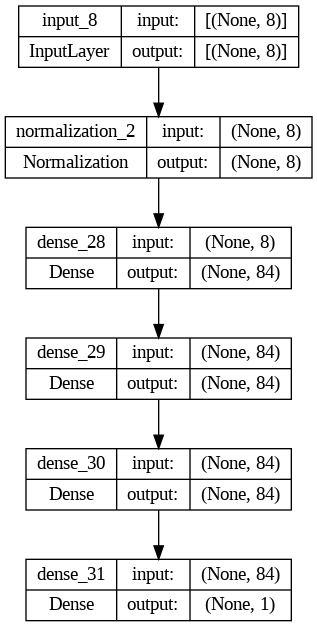

In [159]:
tf.keras.utils.plot_model(model_1, to_file ="Regression_L(84).png", show_shapes=True)

In [160]:
for x, y in test_dataset:
  print(x,y)
  break

tf.Tensor(
[[   8.          2.31       11.036037    0.          0.        141.212
     0.        256.      ]
 [   8.          1.44       10.842494    0.          1.        165.63211
     0.        256.      ]
 [   8.          2.4        10.539416    0.          0.        141.212
  1000.          0.      ]
 [   8.          2.02       10.726663    0.          0.        141.212
  1000.        128.      ]
 [   8.          1.5        10.855945    0.          1.        165.63211
     0.        256.      ]
 [   8.          2.2        10.83097     0.          0.        141.212
  1000.          0.      ]
 [   4.          1.9         9.576277    0.          0.        100.454666
     0.        128.      ]
 [   8.          2.31       11.238891    0.          0.        141.212
     0.        256.      ]
 [   8.          1.34       11.030615    0.          0.        127.67794
     0.          0.      ]
 [   8.          1.19       11.288115    1.          1.        165.63211
     0.        512.      


**Optimisation, fonction de perte(loss) et mesure des performances**


In [161]:
model_1.compile( optimizer = Adam(learning_rate = 0.1),
               loss = MeanAbsoluteError(),
               metrics = RootMeanSquaredError() )

ENTRAINEMENT DU MODEL 1 PROPREMENT DITES

In [162]:
history = model_1.fit(train_dataset, validation_data=valid_dataset, epochs = 100, verbose = 1)

Epoch 1/100
64/64 [==============================] - 1s 4ms/step - loss: 4.2261 - root_mean_squared_error: 7.4303 - val_loss: 1.3869 - val_root_mean_squared_error: 1.6477
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.9193 - root_mean_squared_error: 1.3281 - val_loss: 0.5809 - val_root_mean_squared_error: 0.7299
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5304 - root_mean_squared_error: 0.6750 - val_loss: 0.4952 - val_root_mean_squared_error: 0.5350
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2369 - root_mean_squared_error: 0.3139 - val_loss: 0.1572 - val_root_mean_squared_error: 0.2026
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.1486 - root_mean_squared_error: 0.1923 - val_loss: 0.1794 - val_root_mean_squared_error: 0.2143
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.1392 - root_mean_squared_error: 0.1802 - val_loss: 0.1697 - val_root_m

evaluation du model (perte et performances)

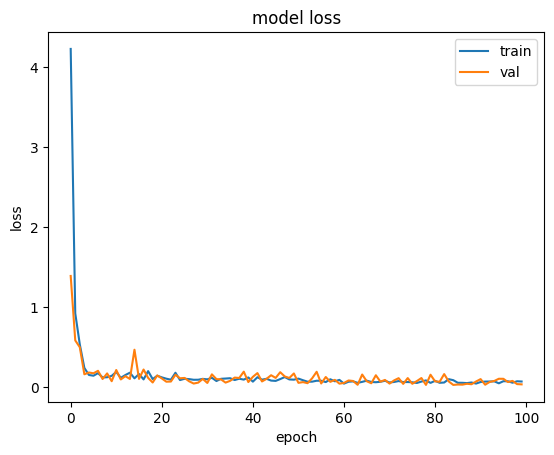

In [163]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

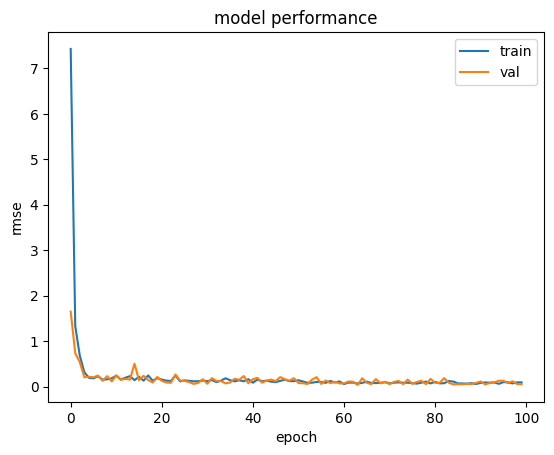

In [164]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [165]:
model_1.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0273 - root_mean_squared_error: 0.0360


[0.027338624000549316, 0.035964082926511765]

**test de prediction**

In [178]:
model_1.predict(tf.expand_dims(X_test[1], axis=0))

1/1 [==============================] - 0s 23ms/step


array([[10.807066]], dtype=float32)

In [177]:
y_test[1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.842494], dtype=float32)>

In [170]:
y_pred= list(model_1.predict(X_test)[:,0])
y_true = list(y_test[:,0].numpy())

4/4 [==============================] - 0s 3ms/step


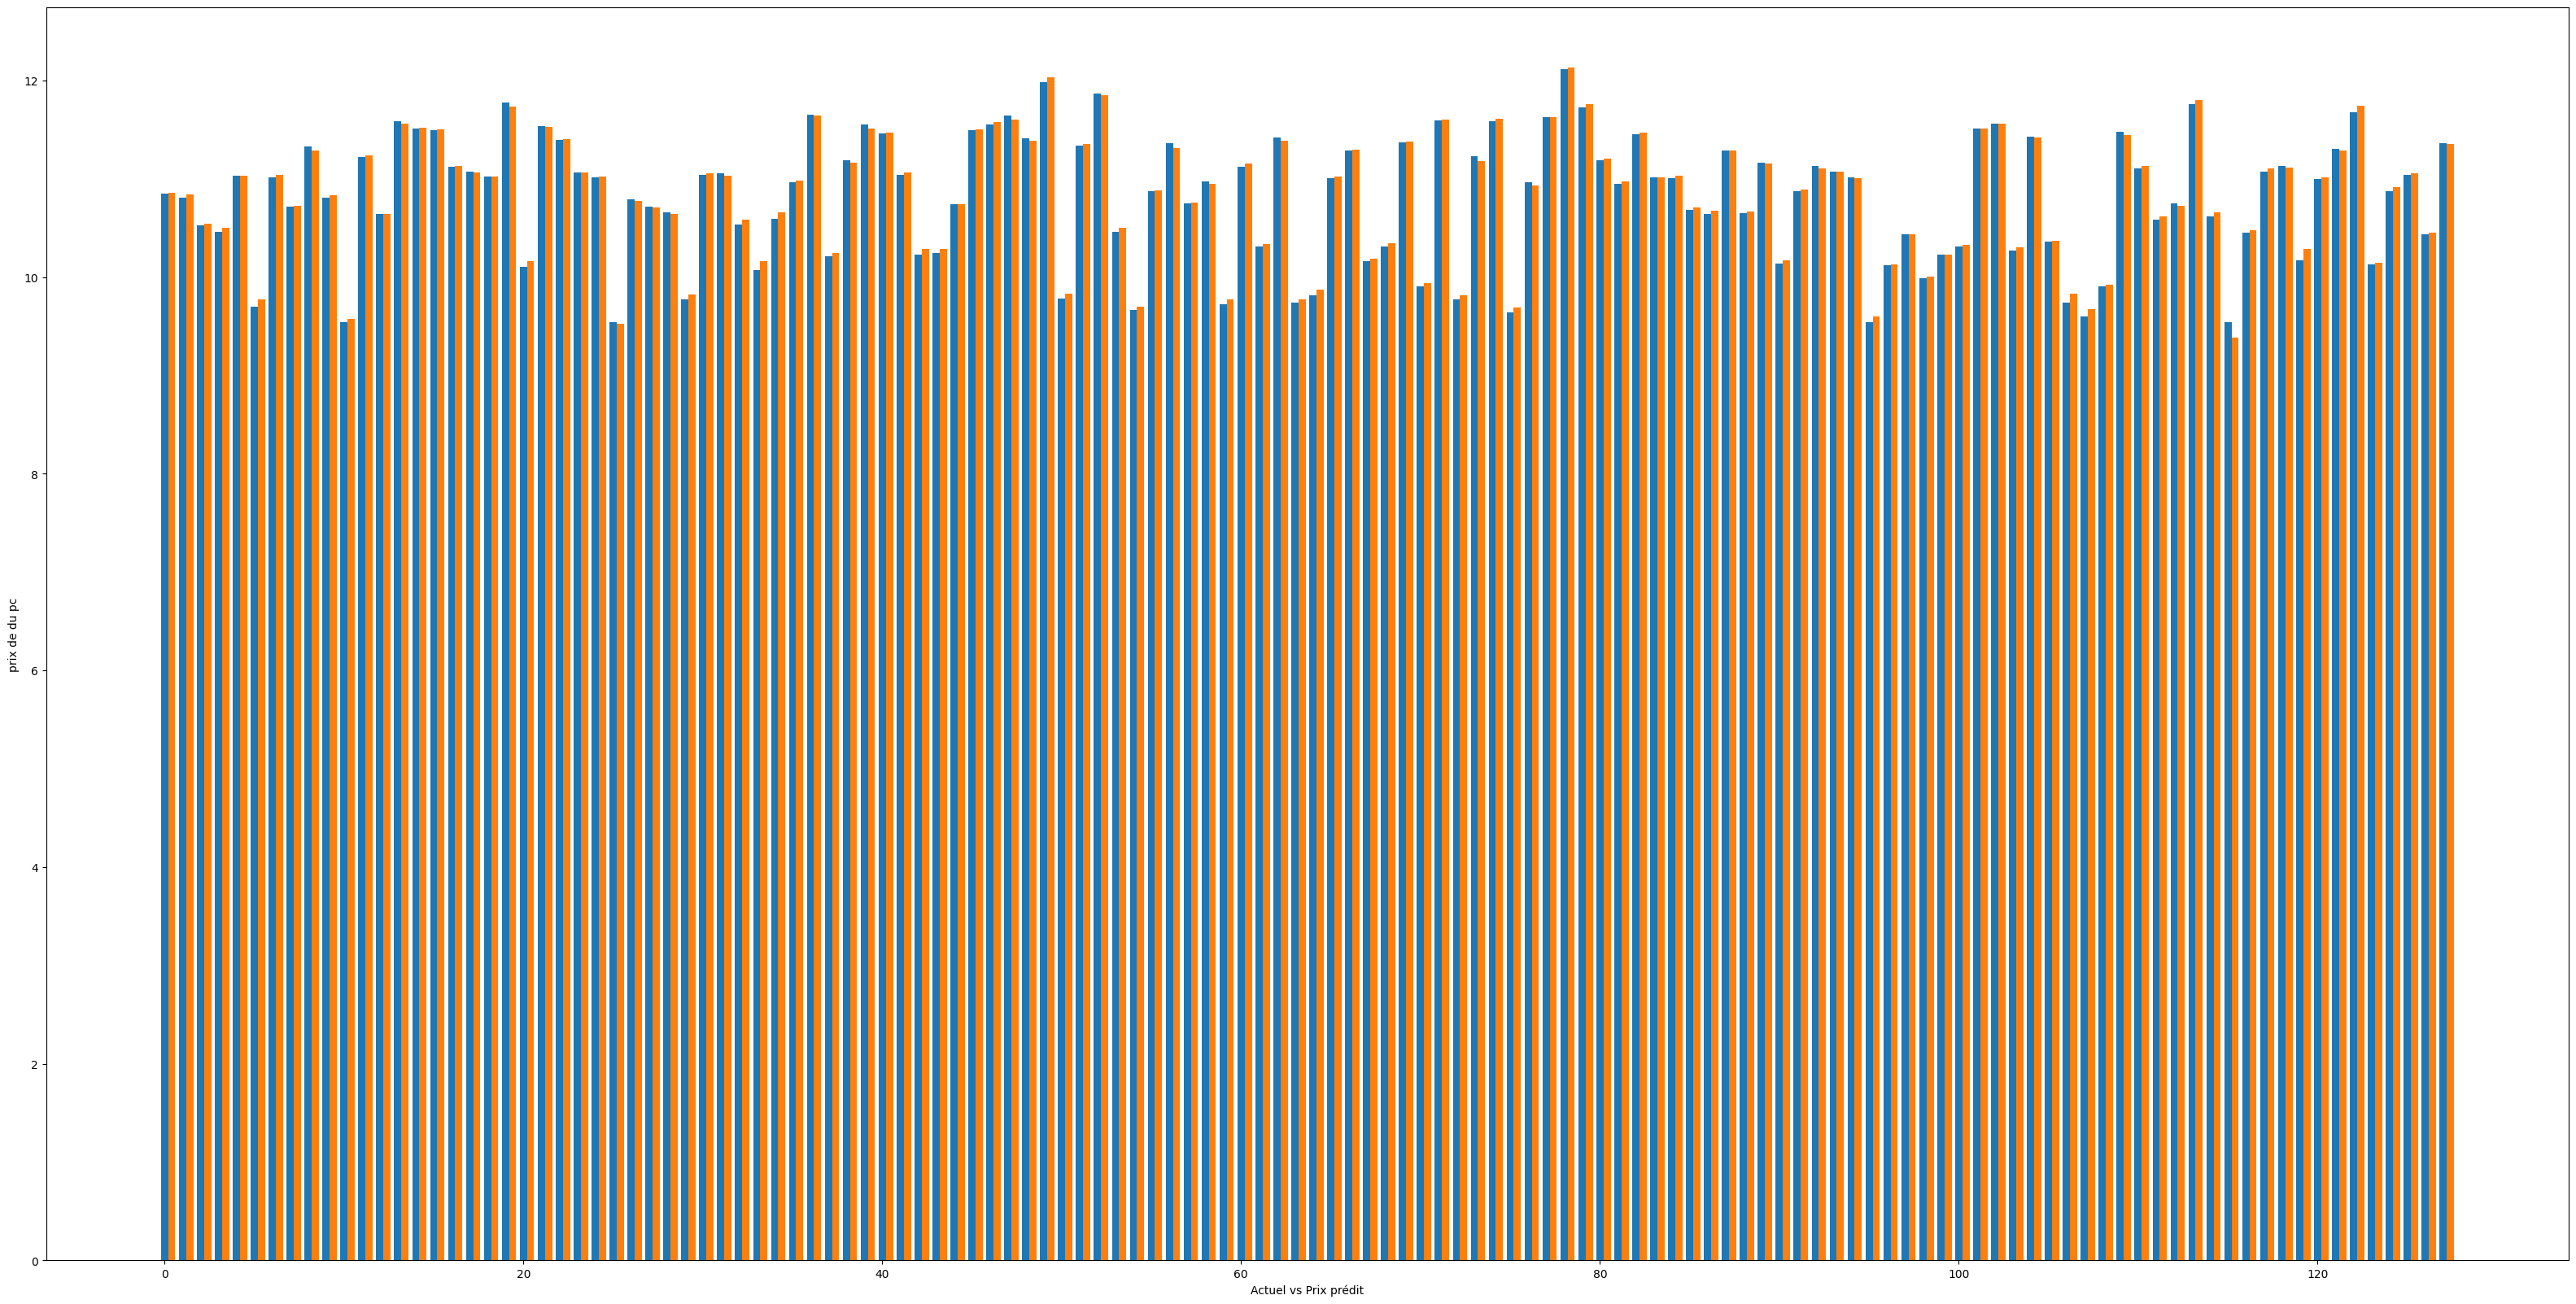

In [174]:
ind = np.arange(128)
plt.figure(figsize = (40, 20))

width = 0.4

plt.bar(ind,
        y_pred,
        width,
        label='prediction du model')
plt.bar(ind + width, y_true, width, label='prix actuel du pc')

plt.xlabel('Actuel vs Prix prédit')
plt.ylabel('prix de du pc')

plt.show()